<a href="https://colab.research.google.com/github/jzyee/water_stress_proj/blob/master/all_in_one___periodic_wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# installs

In [1]:
! pip install --upgrade statsmodels
! pip install tslearn
! pip install pycausalimpact
! pip install ruptures

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.12.0)


# drive mount

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
% cd /content/gdrive/'My Drive'/water_stress_detection

Mounted at /content/gdrive
/content/gdrive/My Drive/water_stress_detection


# Import everything

In [4]:
def combine_eob(site_id, folder_path='data_files/monthly_means/',
                start_name_cov='monthly_mean_',
                end_name_cov='_EBTRN',
                type_list=['pp', 'rr', 'tg', 'tn', 'tx']
                ):
  '''

  fn description: combines all the eob data for a specific site

  notation of 
  RR - daily sum preciptation
  PP - daily sea level pressure
  TG - daily mean temp
  TN - daily min temp
  TX - daily max temp
  
  '''
  


  # file naming convention
  # file_cov = 'wind_monthly_'
  # file_name = 'SWIT345'


  out_df = None

  for idx, data_type in enumerate(type_list):
    file_path = folder_path + start_name_cov + data_type + end_name_cov + '.csv'
    if idx == 0:
      df = pd.read_csv(file_path, parse_dates=True).set_index(['Date'])[[site_id]]
      df = df.rename(columns={site_id: data_type})
    
    else:
      df[data_type] = pd.read_csv(file_path, parse_dates=True).set_index(['Date'])[site_id]

  
  return df

def get_climate_and_ndvi(site_id, file_loc='data_files/processed_harm_ndvi.csv'):
  harm_df = pd.read_csv(file_loc, parse_dates=True)
  harm_df.index = pd.to_datetime(harm_df.iloc[:,0], format='%Y-%m-%d') 
  harm_df = harm_df.iloc[:,1:]
  harm_df.index.name = 'Date'
  # filter out the useable dates
  harm_df = harm_df.loc[(harm_df.index > '1986') & (harm_df.index < '2019')]
  # get the climate data
  df = combine_eob(site_id)
  df = df.loc[(df.index > '1986') & (df.index < '2019')]

  df['ndvi'] = harm_df[site_id]
  return df

def format_cols_casualimpact(df, y_col_name):
  '''
  description: formating column names to fit casual impact function

                example of format:
                data = pd.DataFrame({'x0': x0, 'x1': x1, 'y': y}, 
                                     columns=['y', 'x0', 'x1'])

  returns: dataframe with correct columns names as seen in example

  '''
  old_list = df.columns.to_list()
  new_cols = {}
  
  for idx, col in enumerate(old_list):
    if col != y_col_name:
      new_cols['x'+str(idx)] = col
    else:
      new_cols['y'] = y_col_name

  df.columns = new_cols
  
  #rearranging cols
  rearrange_cols = list([df.columns[-1]]) + list(df.columns[:-1])
  df = df[rearrange_cols]

  return(df)

def make_folder(filename='init_LSTM_model.h5'):

  folder_path = '/model_data/' 
  file_loc = folder_path + filename
  if not os.path.exists(folder_path):
      os.makedirs(folder_path)

  return file_loc


 
def plot_history(history):
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('epochs')
  plt.ylabel('loss(MSE)')
  plt.legend()

def format_spei(spei_df):
  spei_df.index = spei_df['siteID']
  spei_df = spei_df.iloc[:,1:].T
  spei_df.index = pd.to_datetime(spei_df.index, format='x%Y.%m.%d')
  spei_df.index = spei_df.index.rename('date') 
  spei_df = spei_df.resample('M').mean()
  #full years only
  spei_df = spei_df.loc[(spei_df.index > '1986') & (spei_df.index < '2019')]
  return spei_df

def get_climate_ndvi_and_spei(site, file_loc='SPEI_folder/SPEI_monthly_EBTRNsites.csv'):
  spei_df = pd.read_csv(file_loc, parse_dates=True)
  spei_df = format_spei(spei_df)

  climate_ndvi = get_climate_and_ndvi(site)
  climate_ndvi['spei'] = pd.to_numeric(spei_df[site])
  climate_ndvi.index = pd.to_datetime(climate_ndvi.index)
  return climate_ndvi

def norm_raw_data(raw_data):
  norm_data = raw_data.copy()

  for col in raw_data:
    if col not in ['ndvi']:
      min_max_scaler = preprocessing.MinMaxScaler()
      norm_data[col] = min_max_scaler.fit_transform(raw_data[[col]].values)

  return norm_data

def get_all(site):
  out_df = get_climate_ndvi_and_spei(site)

  season_comp = pd.read_csv('synthetic_component/wave.csv', index_col='date')
  season_comp.index = pd.to_datetime(season_comp.index, format='%Y-%m-%d')
  season_comp = season_comp.loc[(season_comp.index > '1986') & (season_comp.index < '2019')]


  out_df = pd.concat([season_comp, out_df], axis=1, sort=False)

  return out_df

def check_drought_year_df(spei_df, d_val, spei_loc='SPEI_folder/SPEI_monthly_EBTRNsites.csv'):
  drought_years = []
  for idx, year in enumerate(spei_df.index.year.unique()):
    mar_2_aug = spei_df[(spei_df.index.month >= 5) & (spei_df.index.month <= 8)]
    site_df = mar_2_aug
    
    year_df = site_df[site_df.index.year == year]
    
    if len(year_df[year_df['spei'] < d_val]) > 0:
      #print(year, 'drought')
      drought_years.append(year)
  
  return drought_years

def get_drought_idxs_df(spei_df, d_val):
  '''
  args
  ____
    - spei_df: pd.DataFrame
  '''
  bps = check_drought_year_df(spei_df, d_val)
  
  copy_df = spei_df.copy()
  copy_df['Date'] = copy_df.index
  copy_df = copy_df.reset_index()
  idxs = []

  dates=[]
  for bp in bps:
    date = spei_df.index[spei_df.index.year == bp][5]
    dates.append(date)
  
  

  idxs = []
  for date in dates:
    idx = copy_df[copy_df['Date'] == date].index.tolist()
    idxs.extend(idx)

  idxs.append(len(spei_df))  
  return idxs

def get_norm_drought_val(raw_data):
  X_std = (-1 - raw_data.min()) / (raw_data.max() - raw_data.min())
  minus_1_norm_val = X_std * (1 - 0) + 0
  return minus_1_norm_val

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from scipy import stats
from functools import partial
import numpy as np
# cpdetect has been modified to fit code
from cpdetect.cpdetect import cpDetector
import os
from causalimpact import CausalImpact
import matplotlib.colors as colors
import matplotlib.cm as cmx
#from bfast import BFASTMonitor
from random import seed
from random import gauss
import seaborn as sns
import ruptures as rpt
from ruptures.metrics import hausdorff, randindex, precision_recall
from keras.models import load_model
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#Supress default INFO logging
import logging, sys
logging.disable(sys.maxsize)

plt.rcParams["figure.figsize"] = (18,6)

import os
os.environ["KERAS_BACKEND"] = "theano"

import warnings
warnings.simplefilter('ignore')
from benchmark import Benchmark_Models
from helper import *
from lstm_model import *
import pandas as pd


# NDVI
harm_df = pd.read_csv('data_files/processed_harm_ndvi.csv', parse_dates=True)
harm_df.index = pd.to_datetime(harm_df.iloc[:,0], format='%Y-%m-%d') 
harm_df = harm_df.iloc[:,1:]
harm_df.index.name = 'Date'

#full years only
harm_df = harm_df.loc[(harm_df.index > '1986') & (harm_df.index < '2019')]

# Season
season_comp = pd.read_csv('synthetic_component/wave.csv', index_col='date')
season_comp.index = pd.to_datetime(season_comp.index, format='%Y-%m-%d')
#full years only
season_comp = season_comp.loc[(season_comp.index > '1986') & (season_comp.index < '2019')]

#high corr
high_corr_site_names = pd.read_csv('data_files/high_corr_site_names.csv', index_col=0)

# just scores for 1 site ( FMMOL )

In [ ]:
# for reproducibility 
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

score_df_list = []
concat_df = {}
# site to be inspectted
site_id = 'SWIT345'

for idx, site_id in enumerate(harm_df.columns):
  
  if idx == 0:
    raw_data = get_all(site_id)
    norm_data = norm_raw_data(raw_data)
    print('workin:',site_id)
    algo_list = [
    ('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
    #('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
    ('pelt', {'decomp_algo': 'STL'}),
    ('binseg', {'decomp_algo': 'STL'})
    ]


    # running benchmark
    true_bp = check_drought_year(site_id)
    bm = Benchmark_Models(algo_list)
    true_idxs = get_drought_idxs(site_id)
    df = bm.run_benchmark(norm_data['ndvi'], true_idxs)
    
    

    score_names = ['f1_score', 'h_score',	'randindex',	'ann_err']
    # display(bm.df)
    if len(concat_df) == 0:
      concat_df = bm.df[score_names].astype(float)
    else:
      concat_df = pd.concat([concat_df, bm.df[score_names].astype(float)], axis=1)



mean_scores_df = concat_df.groupby(by=concat_df.columns, axis=1).mean()
mean_scores_df.index = [x[0] for x in algo_list]
sum_scores_df = concat_df.groupby(by=concat_df.columns, axis=1).sum()
sum_scores_df.index = [x[0] for x in algo_list]
display(mean_scores_df)
display(sum_scores_df)
bm.df

workin: FMMOL


,ann_err,f1_score,h_score,randindex
bayes,-14.0,0.200000,144.0,0.501135
pelt,-6.0,0.571429,62.0,0.922584
binseg,-5.0,0.551724,62.0,0.918082


,ann_err,f1_score,h_score,randindex
bayes,-14.0,0.200000,144.0,0.501135
pelt,-6.0,0.571429,62.0,0.922584
binseg,-5.0,0.551724,62.0,0.918082


,signal,algo,f1_score,h_score,randindex,ann_err,pred_bp
0,"[0.5886985732405595, 0.5548902571851166, 0.521...",bayes,0.2,144,0.501135,-14,"[256, 149, 317, 396]"
1,"[0.5886985732405595, 0.5548902571851166, 0.521...",pelt,0.571429,62,0.922584,-6,"[60, 85, 125, 150, 180, 200, 215, 235, 250, 27..."
2,"[0.5886985732405595, 0.5548902571851166, 0.521...",binseg,0.551724,62,0.918082,-5,"[55, 70, 85, 120, 150, 180, 200, 215, 235, 250..."


In [ ]:
bm.df['pred_bp'][1]

[60, 85, 125, 150, 180, 200, 215, 235, 250, 275, 315, 396]

# 3 CP algo scores for all the sites

## BIC scores

In [ ]:
# for reproducibility 
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

from tqdm import tqdm_notebook as tqdm


score_df_list = []
concat_df = {}
# site to be inspectted
site_id = 'SWIT345'

for idx, site_id in enumerate(tqdm(harm_df.columns)):
  
  if idx >= 0:
    raw_data = get_all(site_id)
    norm_data = norm_raw_data(raw_data)
    norm_drought_val = get_norm_drought_val(raw_data['spei'].values)
    # the drought threshold for the normalized SPEI data
    # print('d val',norm_drought_val)
    
    
    algo_list = [
    ('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
    #('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
    ('pelt', {'decomp_algo': 'STL'}),
    ('binseg', {'decomp_algo': 'STL'})
    ]


    # running benchmark
    true_bp = check_drought_year(site_id)
    bm = Benchmark_Models(algo_list)
    true_idxs = get_drought_idxs_df(norm_data[['spei']], d_val=norm_drought_val)
    df = bm.run_benchmark(norm_data['ndvi'], true_idxs, pen='bic')
    
    

    score_names = ['f1_score', 'h_score',	'randindex',	'ann_err']
    # display(bm.df)
    if len(concat_df) == 0:
      concat_df = bm.df[score_names].astype(float)
    else:
      concat_df = pd.concat([concat_df, bm.df[score_names].astype(float)], axis=1)



mean_scores_df = concat_df.groupby(by=concat_df.columns, axis=1).mean()
mean_scores_df.index = [x[0] for x in algo_list]
sum_scores_df = concat_df.groupby(by=concat_df.columns, axis=1).sum()
sum_scores_df.index = [x[0] for x in algo_list]
display(mean_scores_df)
display(sum_scores_df)

,ann_err,f1_score,h_score,randindex
bayes,-19.162712,0.163885,174.422383,0.398473
pelt,-13.261017,0.379444,86.363322,0.820740
binseg,-14.984746,0.317464,103.779130,0.773130


,ann_err,f1_score,h_score,randindex
bayes,-11306.0,83.909269,96630.0,220.754056
pelt,-7824.0,215.903456,49918.0,474.387677
binseg,-8841.0,178.097146,59673.0,444.549969


## AIC scores

In [ ]:
# for reproducibility 
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

from tqdm import tqdm_notebook as tqdm


score_df_list = []
concat_df = {}
# site to be inspectted
site_id = 'SWIT345'

for idx, site_id in enumerate(tqdm(harm_df.columns)):
  
  if idx >= 0:
    raw_data = get_all(site_id)
    norm_data = norm_raw_data(raw_data)
    #print('workin:',site_id)
    algo_list = [
    ('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
    #('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
    ('pelt', {'decomp_algo': 'STL'}),
    ('binseg', {'decomp_algo': 'STL'})
    ]


    # running benchmark
    true_bp = check_drought_year(site_id)
    bm = Benchmark_Models(algo_list)
    true_idxs = get_drought_idxs(site_id)
    df = bm.run_benchmark(norm_data['ndvi'], true_idxs)
    
    

    score_names = ['f1_score', 'h_score',	'randindex',	'ann_err']
    # display(bm.df)
    if len(concat_df) == 0:
      concat_df = bm.df[score_names].astype(float)
    else:
      concat_df = pd.concat([concat_df, bm.df[score_names].astype(float)], axis=1)



mean_scores_df = concat_df.groupby(by=concat_df.columns, axis=1).mean()
mean_scores_df.index = [x[0] for x in algo_list]
sum_scores_df = concat_df.groupby(by=concat_df.columns, axis=1).sum()
sum_scores_df.index = [x[0] for x in algo_list]
display(mean_scores_df)
display(sum_scores_df)

,ann_err,f1_score,h_score,randindex
bayes,-19.162712,0.163885,174.422383,0.398473
pelt,7.952542,0.605150,30.493220,0.944397
binseg,7.032203,0.588505,34.879661,0.936476


,ann_err,f1_score,h_score,randindex
bayes,-11306.0,83.909269,96630.0,220.754056
pelt,4692.0,357.038336,17991.0,557.194266
binseg,4149.0,347.218232,20579.0,552.520916


# 3 algos 3 sites for observation

workin: FMMOL
workin: Z2
workin: NO


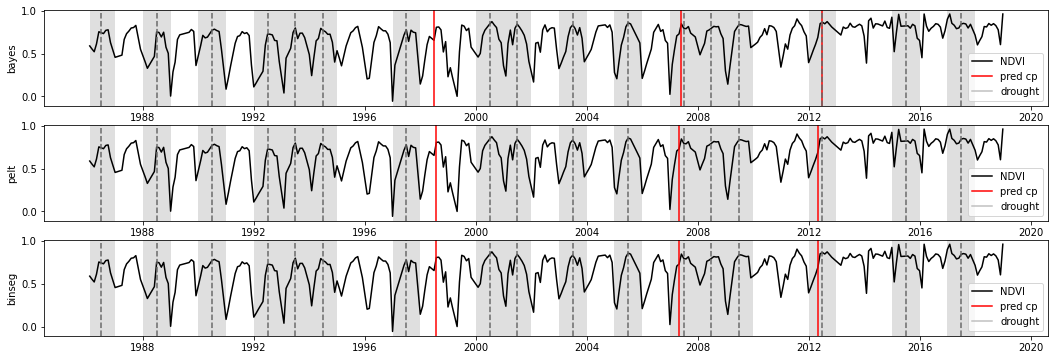

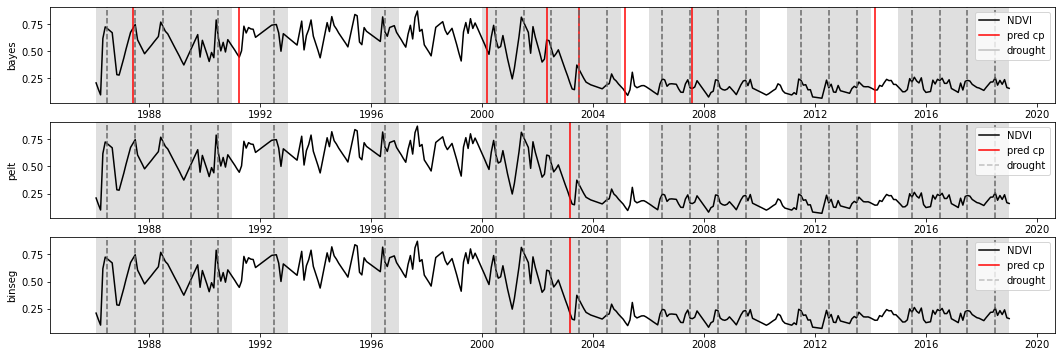

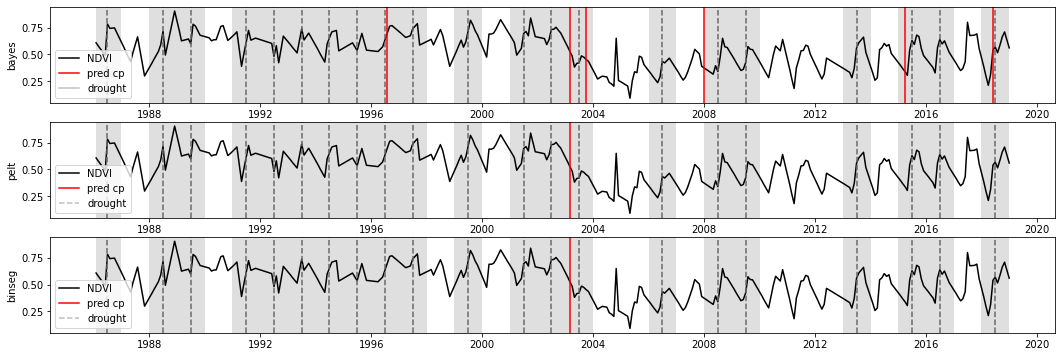

In [ ]:
# for reproducibility 
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

score_df_list = []
concat_df = {}
# site to be inspectted
site_id = 'SWIT345'

for idx, site_id in enumerate(harm_df.columns):
  
  if site_id in ['FMMOL', 'NO' , 'Z2']:
    raw_data = get_all(site_id)
    norm_data = norm_raw_data(raw_data)
    print('workin:',site_id)
    algo_list = [
    ('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
    #('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
    ('pelt', {'decomp_algo': 'STL'}),
    ('binseg', {'decomp_algo': 'STL'})
    ]


    # running benchmark
    true_bp = check_drought_year(site_id)
    bm = Benchmark_Models(algo_list)
    true_idxs = get_drought_idxs(site_id)
    df = bm.run_benchmark(norm_data['ndvi'], true_idxs, pen='bic')
    bm.plot()

# for forecasting

d val 0.31050167722387
length of original dataset:  396
length of add forcast dataset:  408


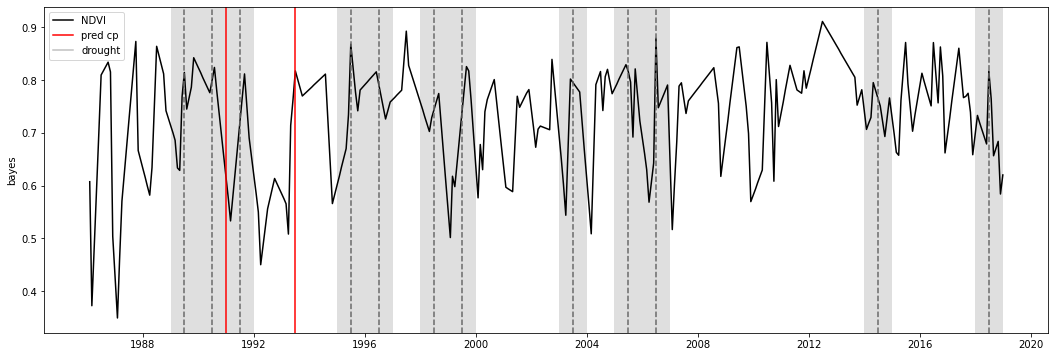

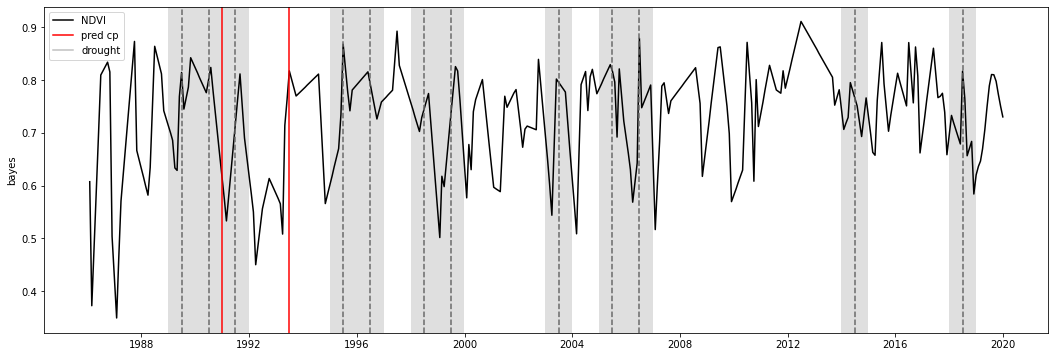

In [ ]:
site_id = 'UK53'

raw_data = get_all(site_id)
norm_data = norm_raw_data(raw_data)
norm_drought_val = get_norm_drought_val(raw_data['spei'].values)
# the drought threshold for the normalized SPEI data
print('d val',norm_drought_val)

# LOAD the model from file
# f = Forcaster()
# f.load_weights('best_LSTM.h5')
# res = f.predict(norm_data.iloc[-12:,:])

# OR

# Train model from new
f2 = Forcaster()
f2.train(norm_data)
res2 = f2.predict(norm_data.iloc[-12:,:])


# add forecase to new data
ext_data = pd.concat([norm_data, res2], axis=0)

print('length of original dataset: ', len(norm_data))
print('length of add forcast dataset: ', len(ext_data))

algo_list = [
    ('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
    ]


# running benchmark
bm = Benchmark_Models(algo_list)
true_idxs = get_drought_idxs_df(norm_data[['spei']], d_val=norm_drought_val)
df = bm.run_benchmark(norm_data['ndvi'], true_idxs)
bm.plot()

# running benchmark
bm = Benchmark_Models(algo_list)
true_idxs = get_drought_idxs_df(ext_data[['spei']], d_val=norm_drought_val )
df = bm.run_benchmark(ext_data['ndvi'], true_idxs)


bm.plot()


# Comparing NDVI and climate times series CPs 

workin: CAN
[5, 41, 53, 65, 77, 89, 101, 113, 137, 149, 173, 185, 209, 233, 245, 269, 329, 353, 389, 396]
[128, 317, 396]


,signal,algo,f1_score,h_score,randindex,ann_err,pred_bp
0,"[0.1952531381563951, 0.25810987373802063, 0.32...",bayes,0.0952381,123,0.680058,-17,"[128, 317, 396]"


,signal,algo,f1_score,h_score,randindex,ann_err,pred_bp
0,"[0.027886155776868694, 0.0, 0.2194493813398208...",bayes,0.4,121,0.639259,1,"[130, 7, 244, 396]"


,signal,algo,f1_score,h_score,randindex,ann_err,pred_bp
0,"[0.026416801134418827, 0.010098615506052816, 0...",bayes,0.5,73,0.81535,0,"[129, 244, 396]"


,signal,algo,f1_score,h_score,randindex,ann_err,pred_bp
0,"[0.05116272885615131, 0.04828653483438011, 0.2...",bayes,0.4,72,0.630612,1,"[245, 128, 388, 396]"


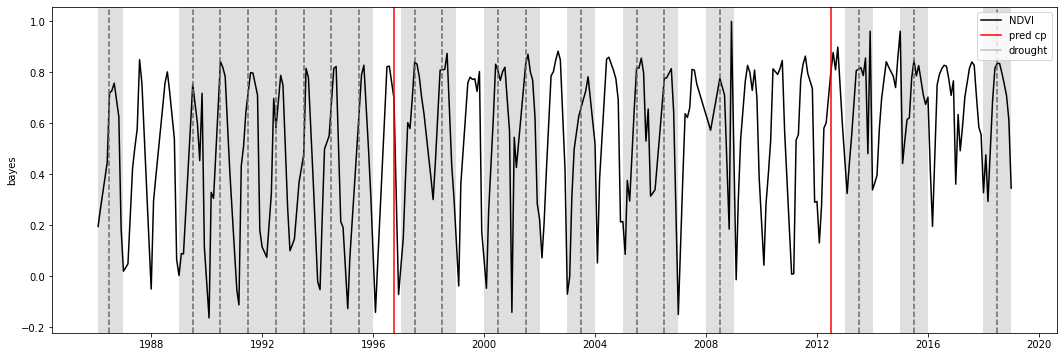

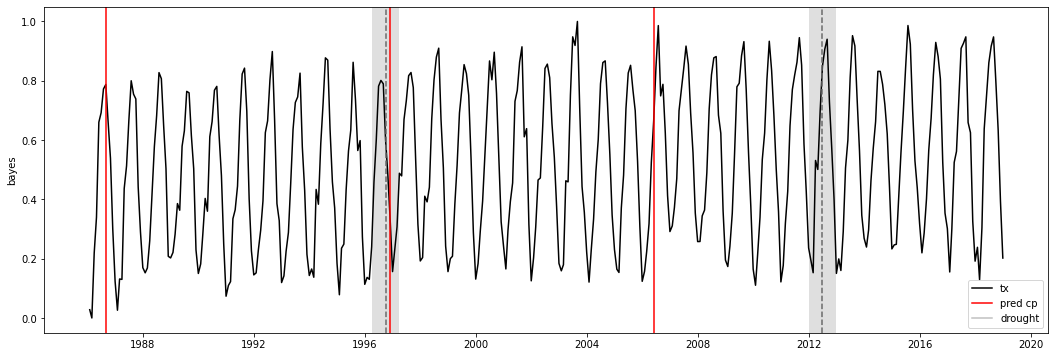

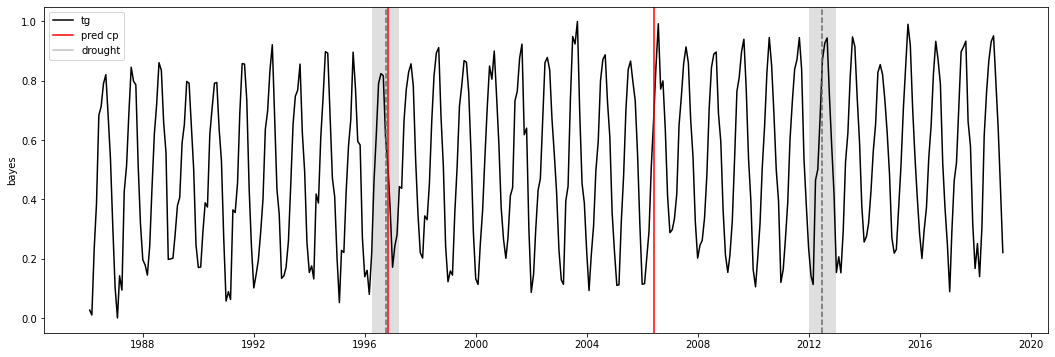

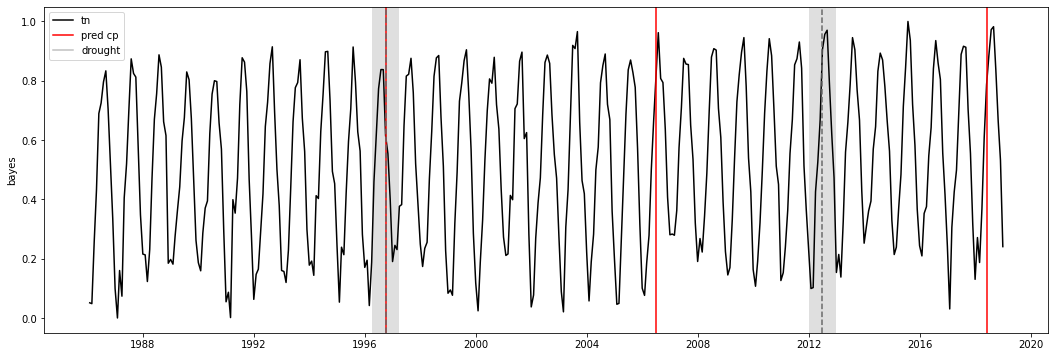

In [ ]:
# for reproducibility 
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

score_df_list = []
concat_df = {}
# site to be inspectted
site_id = 'SWIT345'

for idx, site_id in enumerate(harm_df.columns):
  
  if idx == 5:
    raw_data = get_all(site_id)
    norm_data = norm_raw_data(raw_data)
    print('workin:',site_id)
    algo_list = [
    ('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
    #('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
    #('pelt', {'decomp_algo': 'STL'}),
    #('binseg', {'decomp_algo': 'STL'})
    ]


    # running benchmark
    true_bp = check_drought_year(site_id)
    true_idxs = get_drought_idxs(site_id)
    print(true_idxs)
    bm = Benchmark_Models(algo_list)
    df = bm.run_benchmark(norm_data['ndvi'], true_idxs)

    print(df['pred_bp'].values[0])
    bm2 = Benchmark_Models(algo_list)
    bm2.run_benchmark(norm_data['tx'], df['pred_bp'][0])

    bm3 = Benchmark_Models(algo_list)
    bm3.run_benchmark(norm_data['tg'], df['pred_bp'][0])

    bm4 = Benchmark_Models(algo_list)
    bm4.run_benchmark(norm_data['tn'], df['pred_bp'][0])
    
    
    # choosing variables for casual impact algorithm and formatting for use
    
    # stl_data = norm_data.copy()
    # sel_cov = ['ndvi','tx']
    # for col in sel_cov:
    #   stl = STL(norm_data[[col]], period=12, seasonal=35, robust=True)
    #   res = stl.fit()
    #   stl_data[col] = res.trend

    

    bm.plot()
    display(bm.df)
    bm2.plot(sig_name='tx')
    display(bm2.df)
    bm3.plot(sig_name='tg')
    display(bm3.df)
    bm4.plot(sig_name='tn')
    display(bm4.df)


# using one site to see casual impact of some of the change points (Z2)

d val 0.3279157135224877
length of original dataset:  396
length of add forcast dataset:  408


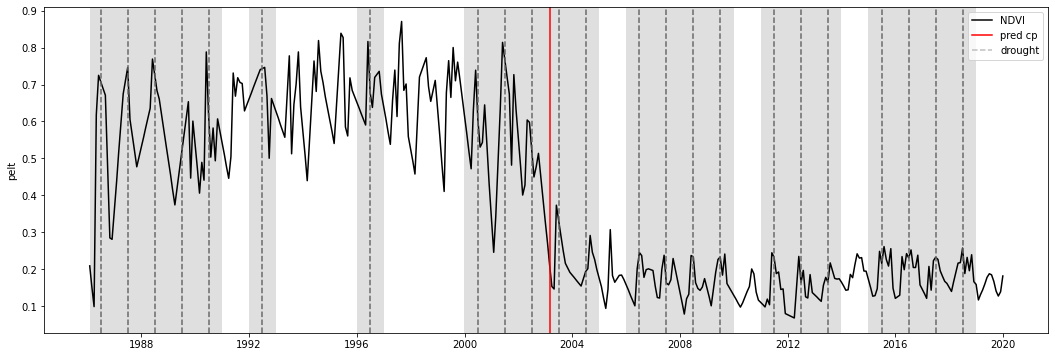

In [ ]:
site_id = 'Z2'

raw_data = get_all(site_id)
norm_data = norm_raw_data(raw_data)
norm_drought_val = get_norm_drought_val(raw_data['spei'].values)
# the drought threshold for the normalized SPEI data
print('d val',norm_drought_val)

# LOAD the model from file
# f = Forcaster()
# f.load_weights('best_LSTM.h5')
# res = f.predict(norm_data.iloc[-12:,:])

# OR

# Train model from new
f2 = Forcaster()
f2.train(norm_data)
res2 = f2.predict(norm_data.iloc[-12:,:])


# add forecase to new data
ext_data = pd.concat([norm_data, res2], axis=0)

print('length of original dataset: ', len(norm_data))
print('length of add forcast dataset: ', len(ext_data))

algo_list = [
    #('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
    ('pelt', {'decomp_algo': 'STL'})
    ]




# running benchmark
bm = Benchmark_Models(algo_list)
true_idxs = get_drought_idxs_df(ext_data[['spei']], d_val=norm_drought_val )
df = bm.run_benchmark(ext_data['ndvi'], true_idxs)


bm.plot()


In [ ]:
raw_data.index[bm.df['pred_bp'][0][0]]

Timestamp('2003-02-28 00:00:00')

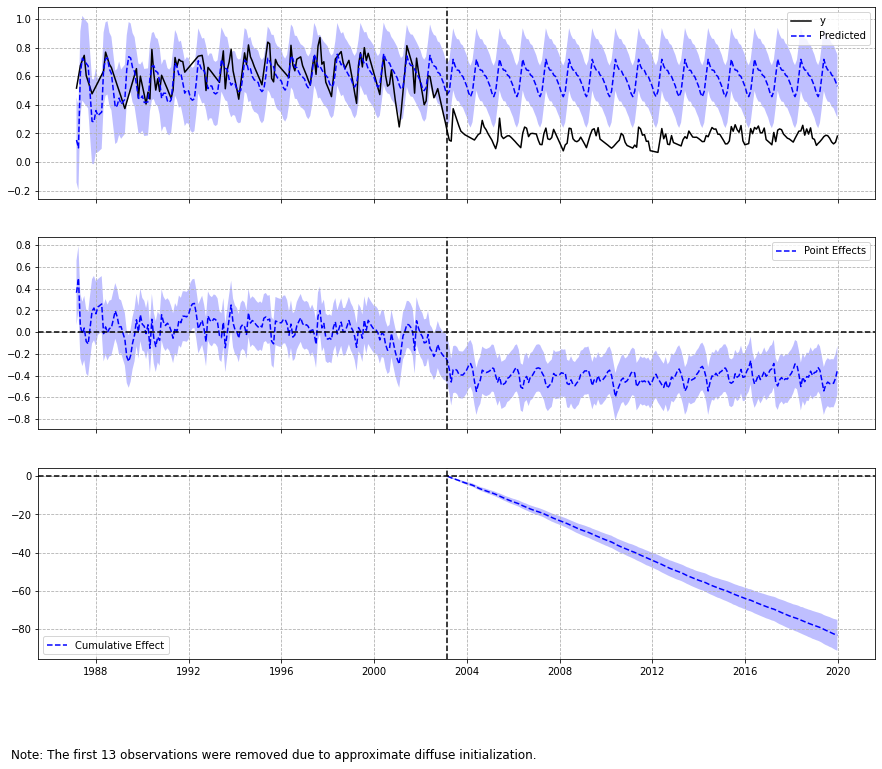

sigma2.irregular              6.276511e-01
sigma2.level                  1.440000e-04
sigma2.freq_seasonal_12(6)    2.417855e-11
dtype: float64


In [ ]:
# getting ALL casual impacts
bm_ci_df, ci_list = bm.get_casual_impacts(ext_data[['ndvi']], ci_sd_None=False)
ci_list[0][0].plot()
print(ci_list[0][0].trained_model.params)

In [ ]:
bm_ci_df

,algo,cp,abs_avg_diff,rel_avg_diff,abs_cum_diff,rel_cum_diff
0,pelt,[205],[-0.4],[-70.4],[-83.4],[-70.4]


In [ ]:
std_scores_df = concat_df.groupby(by=concat_df.columns, axis=1).std()
std_scores_df

,ann_err,f1_score,h_score,randindex
0,3.265912,0.079980,80.809793,0.193488
1,11.191850,0.092901,17.015197,0.028467
2,11.505545,0.099920,27.117754,0.047931


In [ ]:
display(mean_scores_df)


,ann_err,f1_score,h_score,randindex
0,-19.162712,0.163885,174.422383,0.398473
1,7.952542,0.605150,30.493220,0.944397
2,7.032203,0.588505,34.879661,0.936476


In [ ]:
display(sum_scores_df)

,ann_err,f1_score,h_score,randindex
0,-11306.0,83.909269,96630.0,220.754056
1,4692.0,357.038336,17991.0,557.194266
2,4149.0,347.218232,20579.0,552.520916


# using one site to see casual impact of change points(NO)

d val 0.3471752041936117
length of original dataset:  396
length of add forcast dataset:  408


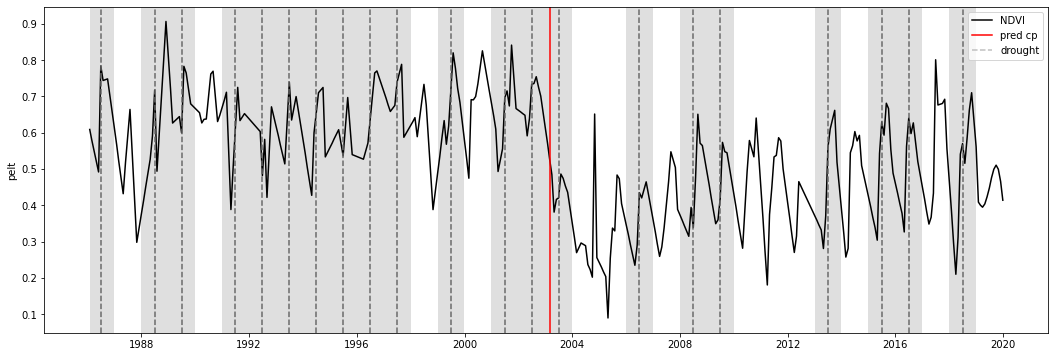

In [ ]:
site_id = 'NO'

raw_data = get_all(site_id)
norm_data = norm_raw_data(raw_data)
norm_drought_val = get_norm_drought_val(raw_data['spei'].values)
# the drought threshold for the normalized SPEI data
print('d val',norm_drought_val)

# LOAD the model from file
# f = Forcaster()
# f.load_weights('best_LSTM.h5')
# res = f.predict(norm_data.iloc[-12:,:])

# OR

# Train model from new
f2 = Forcaster()
f2.train(norm_data)
res2 = f2.predict(norm_data.iloc[-12:,:])


# add forecase to new data
ext_data = pd.concat([norm_data, res2], axis=0)

print('length of original dataset: ', len(norm_data))
print('length of add forcast dataset: ', len(ext_data))

algo_list = [
    ('pelt', {'decomp_algo': 'STL'}),
    ]

# algo_list = [
# ('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
# ('pelt', {'decomp_algo': 'STL'}),
# ('binseg', {'decomp_algo': 'STL'})
# ]



# running benchmark
bm = Benchmark_Models(algo_list)
true_idxs = get_drought_idxs_df(ext_data[['spei']], d_val=norm_drought_val )
df = bm.run_benchmark(ext_data['ndvi'], true_idxs, pen='bic')


bm.plot()

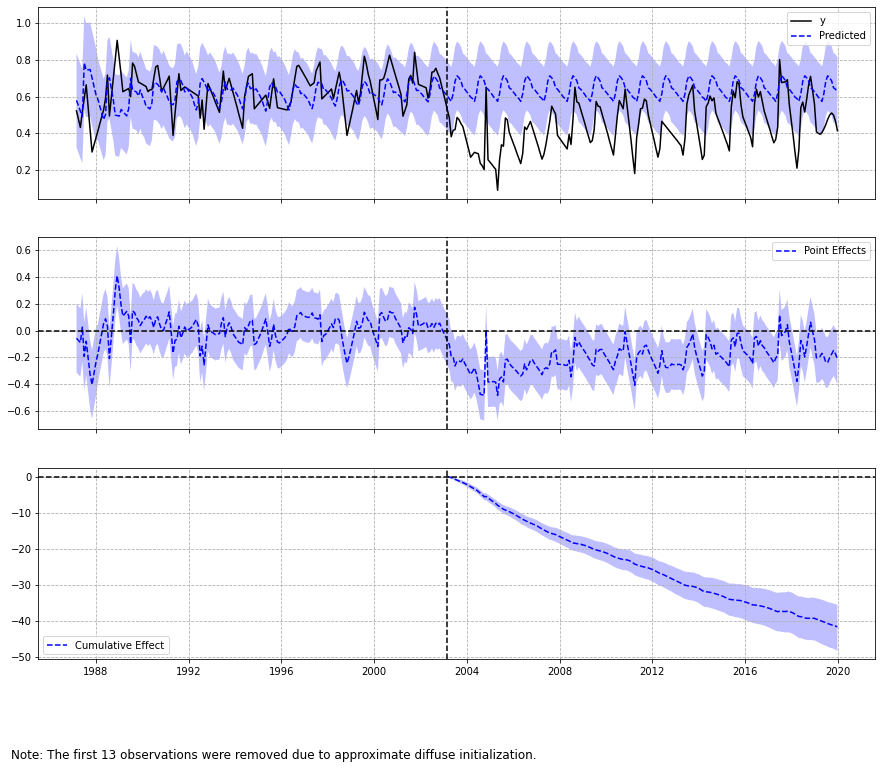

sigma2.irregular              8.313239e-01
sigma2.level                  1.440000e-04
sigma2.freq_seasonal_12(6)    1.927900e-11
dtype: float64


In [ ]:
# getting ALL casual impacts
bm_ci_df, ci_list = bm.get_casual_impacts(ext_data[['ndvi']], ci_sd_None=False)
ci_list[0][0].plot()
print(ci_list[0][0].trained_model.params)

In [ ]:
bm_ci_df

,algo,cp,abs_avg_diff,rel_avg_diff,abs_cum_diff,rel_cum_diff
0,pelt,[205],[-0.2],[-32.1],[-41.6],[-32.1]


# using one site to see casual impact of change points(SWIT345)

SWIT345
d val 0.25369476601427465
length of original dataset:  396
length of add forcast dataset:  408


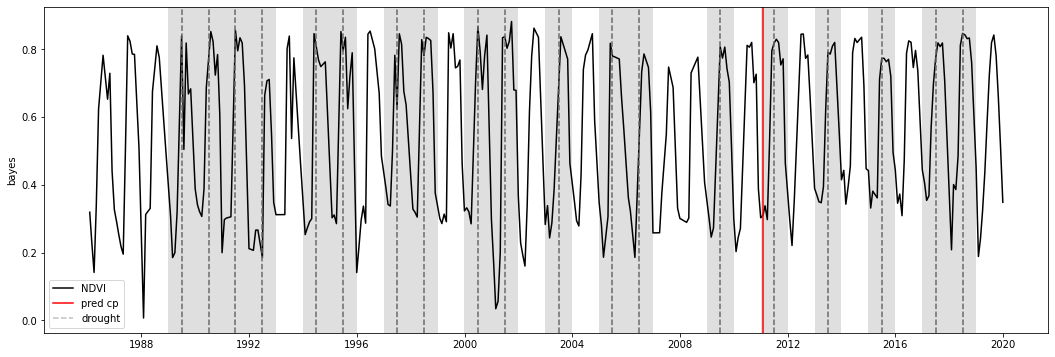

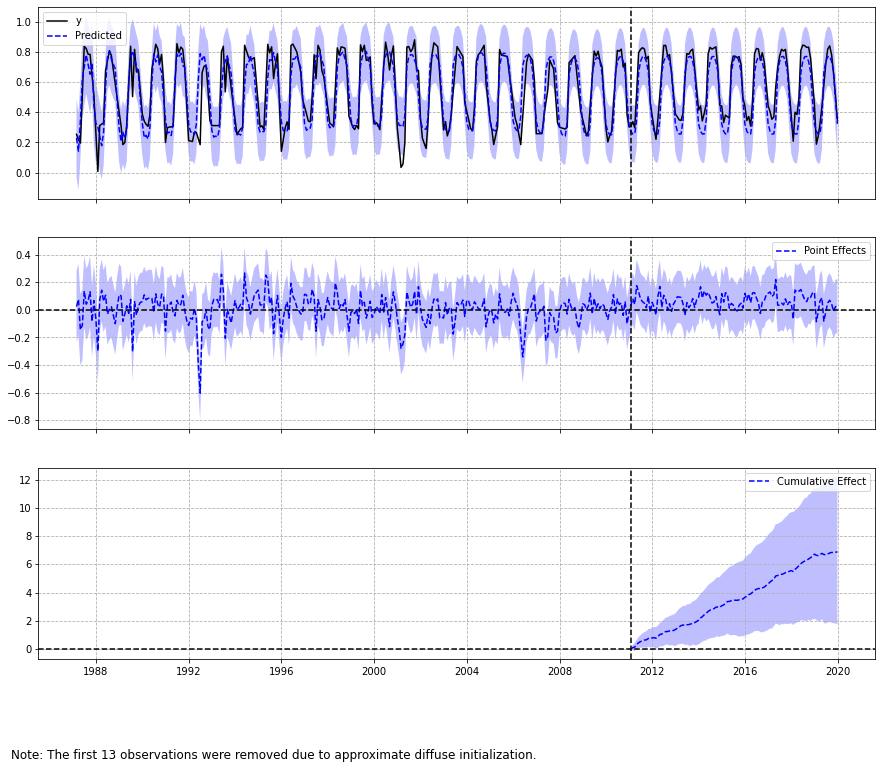

sigma2.irregular              1.630835e-01
sigma2.level                  1.440000e-04
sigma2.freq_seasonal_12(6)    2.493307e-11
dtype: float64


In [6]:

for idx, site_id in enumerate(harm_df.columns):
  if site_id == 'SWIT345':
    print(site_id)
    raw_data = get_all(site_id)
    norm_data = norm_raw_data(raw_data)
    norm_drought_val = get_norm_drought_val(raw_data['spei'].values)
    # the drought threshold for the normalized SPEI data
    print('d val',norm_drought_val)

    # LOAD the model from file
    # f = Forcaster()
    # f.load_weights('best_LSTM.h5')
    # res = f.predict(norm_data.iloc[-12:,:])

    # OR

    # Train model from new
    f2 = Forcaster()
    f2.train(norm_data)
    res2 = f2.predict(norm_data.iloc[-12:,:])


    # add forecase to new data
    ext_data = pd.concat([norm_data, res2], axis=0)

    print('length of original dataset: ', len(norm_data))
    print('length of add forcast dataset: ', len(ext_data))

    algo_list = [
        ('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
        ]




    # running benchmark
    bm = Benchmark_Models(algo_list)
    true_idxs = get_drought_idxs_df(ext_data[['spei']], d_val=norm_drought_val )
    df = bm.run_benchmark(ext_data['ndvi'], true_idxs, pen='bic')


    bm.plot()
    # getting first cp casual impacts
    bm_ci_df, ci_list = bm.get_casual_impacts(ext_data[['ndvi']], ci_sd_None=False)
    ci_list[0][0].plot()
    print(ci_list[0][0].trained_model.params)

## how to view the relative average diff

In [10]:
bm_ci_df

,algo,cp,abs_avg_diff,rel_avg_diff,abs_cum_diff,rel_cum_diff
0,bayes,[300],[0.1],[12.2],[6.9],[12.2]


# an exmaple on how to display the negative casual impacts

,signal,algo,f1_score,h_score,randindex,ann_err,pred_bp
0,"[0.6073940124573036, 0.3722794959908362, 0.481...",bayes,0.142857,300,0.356826,-10,"[89, 59, 396]"
1,"[0.6073940124573036, 0.3722794959908362, 0.481...",pelt,0.391304,46,0.89533,22,"[5, 15, 25, 30, 40, 55, 60, 70, 85, 90, 100, 1..."
2,"[0.6073940124573036, 0.3722794959908362, 0.481...",binseg,0.391304,46,0.89533,22,"[5, 15, 25, 30, 40, 55, 60, 70, 85, 90, 100, 1..."


,algo,cp,cum_diff
0,bayes,"[89, 59]","[17.83716561920596, 2.958708348418753]"
1,pelt,"[15, 25, 30, 40, 55, 60, 70, 85, 90, 100, 115,...","[41.44514033437531, 23.171879051080737, 17.462..."
2,binseg,"[15, 25, 30, 40, 55, 60, 70, 85, 90, 100, 115,...","[41.44514033437531, 23.171879051080737, 17.462..."


,algo,cp,cum_diff
0,bayes,[],[]
1,pelt,"[55, 325, 330, 335, 355, 380, 385, 390]","[-1.004539627296623, -1.2551539935848126, -1.6..."
2,binseg,"[55, 325, 330, 335, 355, 380, 385, 390]","[-1.004539627296623, -1.2551539935848126, -1.6..."


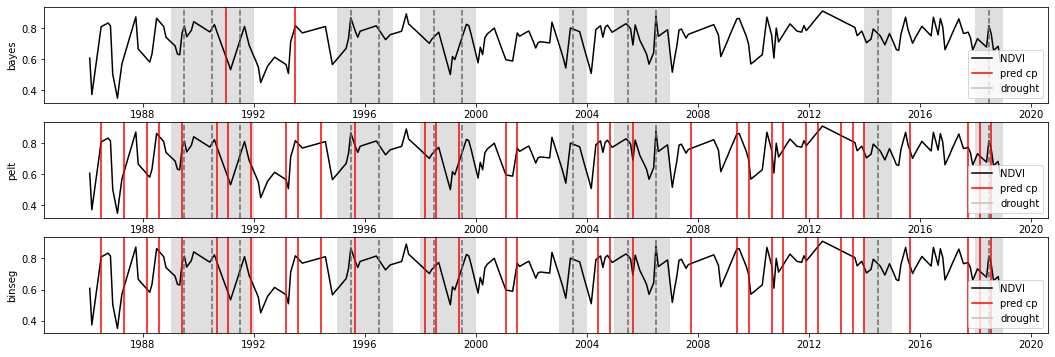

In [ ]:
# site to be inspectted
site_id = 'SWIT345'

# initialize dataframe for the site
raw_data = get_climate_ndvi_and_spei(site_id)
norm_data = norm_raw_data(raw_data)
cs_data_df = get_climate_and_ndvi(site_id)

algo_list = [
('bayes', {'decomp_algo': 'STL', 'distribution': 'normal', 'log_odds_threshold': 0}),
('pelt', {'decomp_algo': 'STL'}),
('binseg', {'decomp_algo': 'STL'})
]

# running benchmark
true_bp = check_drought_year(site_id)
bm = Benchmark_Models(algo_list)
true_idxs = get_drought_idxs(site_id)
df = bm.run_benchmark(norm_data['ndvi'], true_idxs)

# display the results from the benchmark
display(df)
# display the change points from
bm.plot()

# choosing variables for casual impact algorithm and formatting for use
all_formatted_data_df = format_cols_casualimpact(cs_data_df, 'ndvi')

# getting ALL casual impacts
ci_df = bm.get_casual_impacts(all_formatted_data_df)

# getting the neg casual impacts
neg_ci_df = bm.get_casual_impacts(all_formatted_data_df, only_neg=True)

display(ci_df)
display(neg_ci_df)

